In [48]:
# import whisper
import pyaudio
import numpy as np
import wave
import os
import noisereduce as nr
import matplotlib.pyplot as plt
import keyboard
from IPython.display import Audio, display
import openl3  # Import openl3 for extracting embeddings
import json

In [49]:
# Input path of embeddings json
input_file = "embeddings/embeddings.json"

# Function to calculate the mean of embeddings
def calculate_mean(embeddings):
    return np.mean([np.array(embedding) for timestamp, embedding in embeddings.items()], axis=0)

# Load the stored embedding from the JSON file
with open(input_file, 'r') as json_file:
    stored_data = json.load(json_file)

In [ ]:
# Preload model
model = openl3.models.load_audio_embedding_model(input_repr="mel256", content_type="music",
                                                 embedding_size=512)

In [50]:
# List available input audio devices and their names
p = pyaudio.PyAudio()
print('Available input devices:')
for i in range(p.get_device_count()):
    device_info = p.get_device_info_by_index(i)
    print(f'{i}: {device_info["name"]}')

Available input devices:
0: Microsoft Sound Mapper - Input
1: Mic in at front panel (black) (
2: Stereo Mix (Realtek High Defini
3: Microphone (Realtek High Defini
4: Microsoft Sound Mapper - Output
5: Speaker/Headphone (Realtek High
6: Microphone (Realtek HD Audio Mic input)
7: Speakers (Realtek HD Audio output)
8: Mic in at front panel (black) (Mic in at front panel (black))
9: Stereo Mix (Realtek HD Audio Stereo input)


In [51]:
# Select the desired input device by its ID (replace with the appropriate ID)
selected_device_id = 1  # Change this to the ID of your desired input device

# Record audio from the selected input device
print(f'Recording audio will use device: "{p.get_device_info_by_index(selected_device_id)["name"]}"')

Recording audio will use device: "Mic in at front panel (black) ("


In [52]:
# Function to start recording
def start_recording():
    global recording
    recording = True
    print('Recording audio. Press the space key to stop...')

# Function to stop recording
def stop_recording():
    global recording
    recording = False
    print('Recording stopped.')

# Function to reduce noise from audio
def reduce_noise(audio_data, sample_rate):
    # Apply noise reduction using the noisereduce library
    reduced_audio = nr.reduce_noise(y=audio_data, sr=sample_rate)
    return reduced_audio

# Set the parameters for audio recording
sample_rate = 16000  # You can adjust this based on your needs
duration = 10  # Maximum recording duration in seconds

# Initialize recording status
recording = False
audio = []

# Callback function for audio recording
def audio_callback(in_data, frame_count, time_info, status):
    if recording:
        audio.append(in_data)
    return (in_data, pyaudio.paContinue)

# Initialize PyAudio
p = pyaudio.PyAudio()

# Open an audio stream for recording
stream = p.open(format=pyaudio.paInt16,
                channels=1,
                rate=sample_rate,
                input=True,
                input_device_index=selected_device_id,
                frames_per_buffer=1024,
                stream_callback=audio_callback)

# Wait for the space key to start recording
print('Press the space key to start recording...')
keyboard.wait('space')
start_recording()

# Wait for the space key to stop recording
print('Recording audio. Press the space key to stop...')
keyboard.wait('space')
stop_recording()

# Close the audio stream
stream.stop_stream()
stream.close()
p.terminate()

Press the space key to start recording...
Recording audio. Press the space key to stop...
Recording audio. Press the space key to stop...
Recording stopped.


In [53]:
tmp_path = "tmp"
os.makedirs(tmp_path, exist_ok=True)

# Define the output file path
tmp_output_file = os.path.join(tmp_path, 'runtime-og.wav')

# Save the recorded audio as a WAV file
if audio:
    audio_data = b''.join(audio)
    with wave.open(tmp_output_file, 'wb') as wf:
        wf.setnchannels(1)  # Mono audio
        wf.setsampwidth(p.get_sample_size(pyaudio.paInt16))
        wf.setframerate(sample_rate)
        wf.writeframes(audio_data)

    print(f'Audio saved as {tmp_output_file}')
else:
    print('No audio recorded.')

# Reduce noise from the recorded audio
if os.path.exists(tmp_output_file):
    with wave.open(tmp_output_file, 'rb') as wf:
        audio_data = wf.readframes(-1)
        audio_data = np.frombuffer(audio_data, dtype=np.int16)
        sample_rate = wf.getframerate()
    
    # Reduce noise from the recorded audio
    reduced_audio = reduce_noise(audio_data, sample_rate)
    
    # Save the reduced audio
    reduced_output_file = os.path.join(tmp_path, 'runtime-clean.wav')
    with wave.open(reduced_output_file, 'wb') as wf:
        wf.setnchannels(1)  # Mono audio
        wf.setsampwidth(p.get_sample_size(pyaudio.paInt16))
        wf.setframerate(sample_rate)
        wf.writeframes(reduced_audio.tobytes())
    
    print(f'Noise reduced audio saved as {reduced_output_file}')

Audio saved as tmp\runtime-og.wav
Noise reduced audio saved as tmp\runtime-clean.wav


Numerical representation of the reduced audio:
[ 0 -1  0 ...  0  0  0]


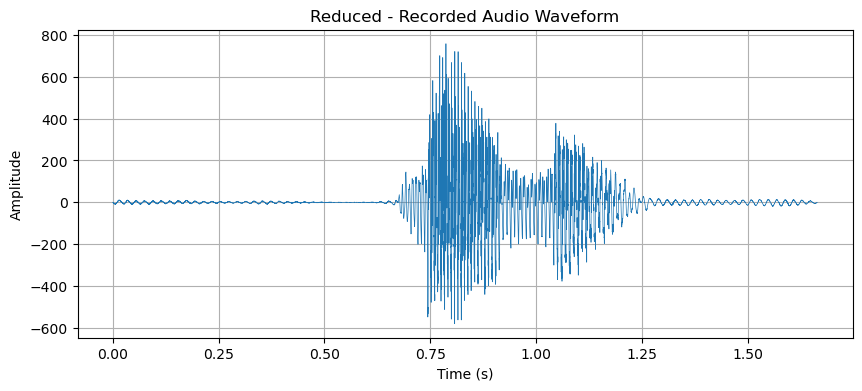

1/1 [==============================] - 6s 6s/step
Predicted word: sifuri


In [70]:

# Function to detect speech using a threshold
def is_speech(audio_data, threshold=100):
    # You may need to adjust the threshold value based on your audio input
    return np.max(np.abs(audio_data)) > threshold

# Function to extract speech segments from audio data
def extract_speech_segments(audio_data, sample_rate, threshold=100):
    # Initialize variables for segment extraction
    start_index = None
    end_index = None
    segments = []
    min_duration = .001

    for i, amplitude in enumerate(audio_data):
        if amplitude > threshold and start_index is None:
            start_index = i
        elif amplitude <= threshold and start_index is not None:
            end_index = i
            segment = audio_data[start_index:end_index]
            
            # Check if segment duration is at least min_duration seconds
            if len(segment) >= int(min_duration * sample_rate):
                segments.append(segment)
            
            start_index = None

    # Convert segments to a list of numpy arrays
    segments = [np.array(segment) for segment in segments]

    return segments

# Load the recorded audio file
audio_file = tmp_path + '/runtime.wav'

# Open the audio file if exist
if os.path.exists(reduced_output_file):
    with wave.open(reduced_output_file, 'rb') as wf:
        # Get audio data
        audio_data = wf.readframes(-1)
        audio_data = np.frombuffer(audio_data, dtype=np.int16)

        # Get sample rate and duration
        sample_rate = wf.getframerate()
        duration = len(audio_data) / sample_rate

    # Create a time array for x-axis (in seconds)
    time = np.linspace(0, duration, len(audio_data))
    
    # # Adjust NumPy print options to display the full array without truncation
    # np.set_printoptions(threshold=np.inf)

    # Print the numerical representation of the audio
    print('Numerical representation of the reduced audio:')
    print(audio_data)

    # Plot the audio waveform
    plt.figure(figsize=(10, 4))
    plt.plot(time, audio_data, lw=0.5)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Reduced - Recorded Audio Waveform')
    plt.grid(True)
    plt.show()

    # Play the recorded audio in the notebook
    display(Audio(filename=reduced_output_file))


    # Extract features from the audio data using openl3
    live_embeddings, _ = openl3.get_audio_embedding(audio=audio_data, sr=16000, model=model)

    # Compare live_embeddings with the stored embeddings
    best_match = None
    best_similarity = -1  # Initialize with a low value

    for entry in stored_data:
        stored_word = entry["word"]
        stored_embeddings = entry["embeddings"]

        # Calculate similarity or distance (e.g., cosine similarity)
        similarity = np.dot(live_embeddings, calculate_mean(stored_embeddings).T) / (
            np.linalg.norm(live_embeddings) * np.linalg.norm(calculate_mean(stored_embeddings))
        )

        if np.any(similarity > best_similarity):  # Use np.any to check if any element is greater
            best_similarity = np.max(similarity)  # Get the maximum similarity value
            best_match = stored_word

    print("Predicted word:", best_match)

    
    # # Extract speech segments from the audio using the threshold
    # speech_segments = extract_speech_segments(audio_data, sample_rate)
    # print(f"Found segments: {len(speech_segments)}")

    # if len(speech_segments) > 0:
    #     print(f"Processing {reduced_output_file}...")

    #     # Extract features from each speech segment using openl3 and plot
    #     for i, segment in enumerate(speech_segments):
    #         # audio_embeddings, timestamps = openl3.get_audio_embedding(segment, sample_rate, model=openl3_model)

    #         # Create a time vector for plotting
    #         time_vector = np.arange(0, len(segment)) / sample_rate

    #         # Plot the segment
    #         plt.figure(figsize=(10, 4))
    #         plt.plot(time_vector, segment)
    #         plt.title(f'Speech Segment {i+1} from {reduced_output_file}')
    #         plt.xlabel('Time (s)')
    #         plt.ylabel('Amplitude')
    #         plt.grid(True)
    #         plt.show()

    #         # Display the audio segment for preview
    #         display(Audio(segment, rate=sample_rate))

    #         # You can also save the plot to a file if needed
    #         # plt.savefig(f'speech_segment_{i+1}.png')

    #         # # Append the processed audio segment to the list
    #         # processed_segments.append({
    #         #     'file': filename,
    #         #     'segment': segment.tolist(),
    #         #     'embeddings': audio_embeddings.tolist()
    #         # })
